In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(16393, 2)
dim1 0.6202247191011236
dim2 0.6060301507537689
dim3 0.7092661691542289
dim4 0.5909442724458205


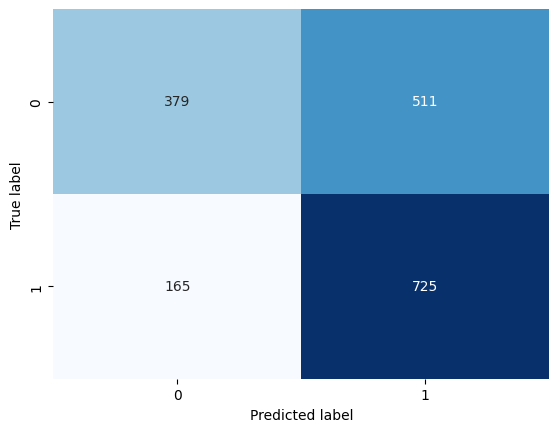

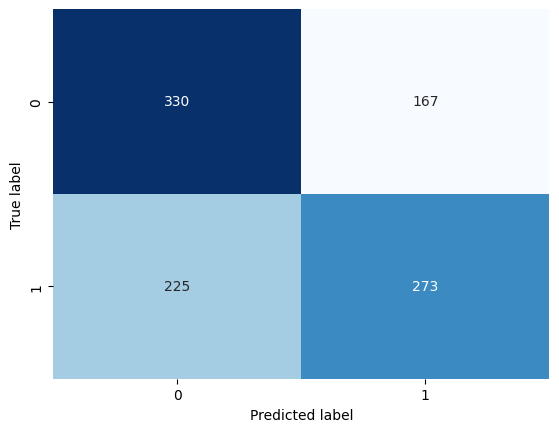

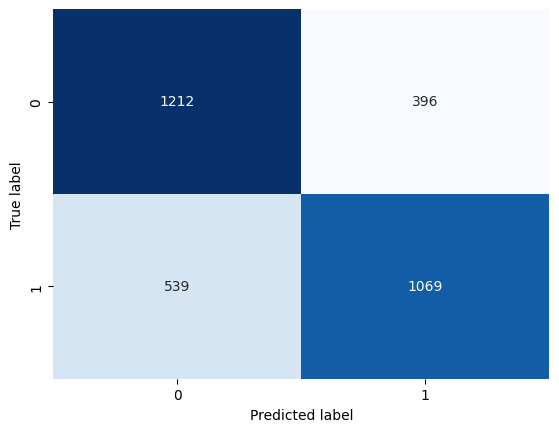

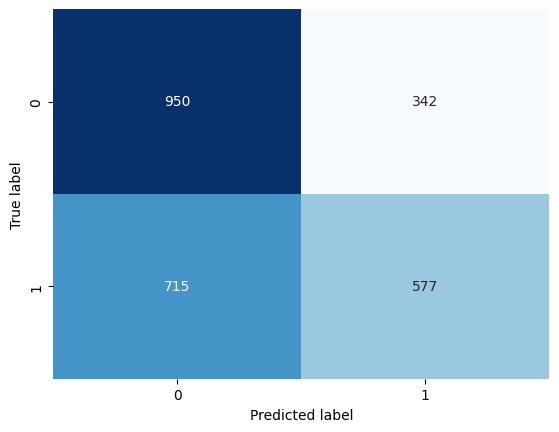

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.sparse import vstack
import os
import sys
import gc

def make_dim_dataset(df, dim, train_size=0.8):
  min_size = np.min(df[dim].value_counts())
  a = df[df[dim]==0].sample(min_size, random_state=42)
  b = df[df[dim]==1].sample(min_size, random_state=42)
  interweaved_rows = [val for pair in zip(a.values, b.values) for val in pair]
  col_names = df.columns.tolist()
  new_df = pd.DataFrame(data=interweaved_rows, columns=col_names)
  num_train = int(len(new_df) * train_size)
  new_df.loc[:num_train, 'set'] = 'train'
  new_df.loc[num_train:, 'set'] = 'test'
  return new_df

def make_vectorizer(df, max_features=None):
  # fit vectorizer only on training data
  data = df[df['set']=='train']['posts']
  # data = df['posts']
  vectorizer = TfidfVectorizer(max_features=max_features)
  vectorizer.fit(data)
  return vectorizer

def plotCM(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

# Define path to project folder
# my_dir = '/content/drive/MyDrive/EECS_448/project/'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS_448/project/datasets/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

sys.path.append(GOOGLE_DRIVE_PATH)

# Define Path to our data
# data_path = os.path.join(my_dir, 'datasets', 'processed_reddit_mbti.csv')
# data_path2 = os.path.join(my_dir, 'datasets', 'processed_kaggle.csv')
# data_path = os.path.join(my_dir, 'datasets', 'bert_reddit_mbti.csv')

# Read the data into df
df1 = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH,'processed_reddit_mbti.csv'))
# main_df = (df.set_index('type')['posts'].str.split('\|\|\|', expand=True)
          # .stack().reset_index(level=1, drop=True).reset_index(name='posts'))
df2 = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH,'processed_kaggle.csv'))
main_df = pd.concat([df1, df2], ignore_index=True)

# drop entries with empty fields
main_df = main_df.dropna()
main_df['type'] = main_df['type'].apply(lambda x: x.lower())
print(main_df.shape)
# convert type to individual columns
main_df[['dim1', 'dim2', 'dim3', 'dim4']] = main_df['type'].apply(lambda x: pd.Series([1 if y in 'estj' else 0 for y in list(x)]))

# make the datasets for the individual datasets
dfs = {x: make_dim_dataset(main_df, x) for x in ['dim1','dim2','dim3','dim4' ]}

# Create and fit vectorizers
vrizers = {x: make_vectorizer(dfs[x]) for x in ['dim1','dim2','dim3','dim4' ]}

# Initialize models
models = {x: SGDClassifier(loss='log_loss', random_state=42) for x in ['dim1','dim2','dim3','dim4' ]}
accuracies = []
scores = []
for dim in ['dim1', 'dim2', 'dim3', 'dim4']:
  gc.collect()
  df = dfs[dim]
  vectorizer = vrizers[dim]
  model = models[dim]
  chunk_size = 10000
  train_len = len(df[df['set']=='train'].index)
  # Loop over the data in chunks and partial fit the model
  for i in range(0, train_len, chunk_size):
    # Vectorize the text data
    X_train_chunk = vectorizer.transform(df[df['set']=='train']['posts'])[i:i+chunk_size]
    y_train_chunk = df[df['set']=='train'][dim][i:i+chunk_size]
    # Partial fit the model on the chunk of data
    model.partial_fit(X_train_chunk, y_train_chunk, classes=[0, 1])
  X_test = vectorizer.transform(df[df['set']=='test']['posts'])
  y_test = df[df['set']=='test'][dim]
  y_pred = model.predict(X_test)
  scores.append(model.coef_[0])
  accuracies.append(model.score(X_test, y_test))
  print(dim, accuracies[-1])
  plotCM(y_test, y_pred)




Look at scores and word clouds

In [ ]:
from wordcloud import WordCloud

Highest weighted word for E: ne
Highest weighted word for I: look


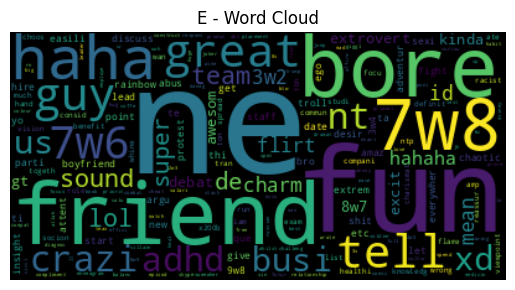

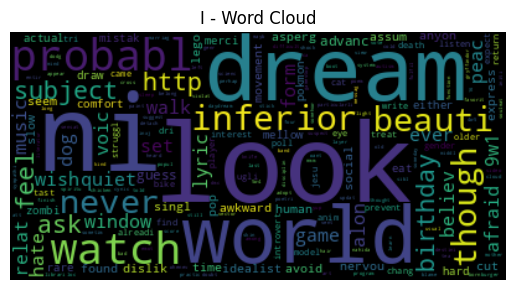

Highest weighted word for S: si
Highest weighted word for N: idea


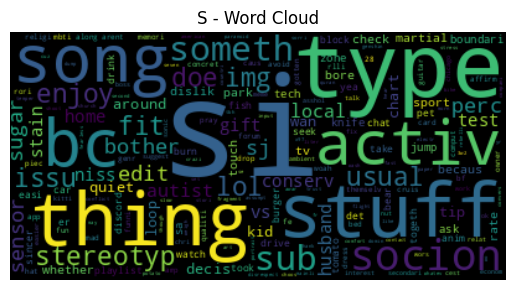

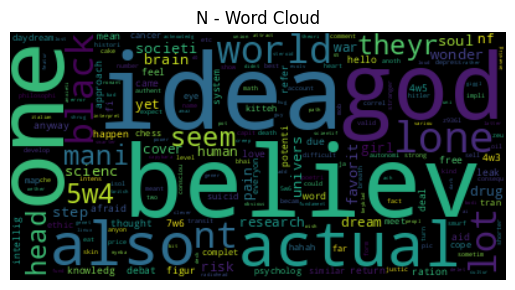

Highest weighted word for T: nt
Highest weighted word for F: feel


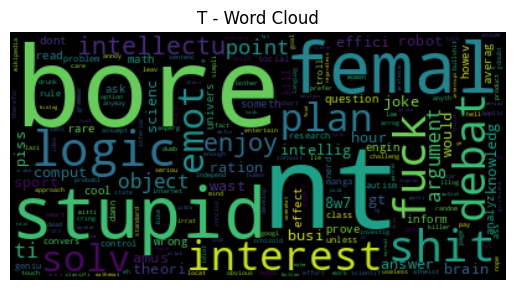

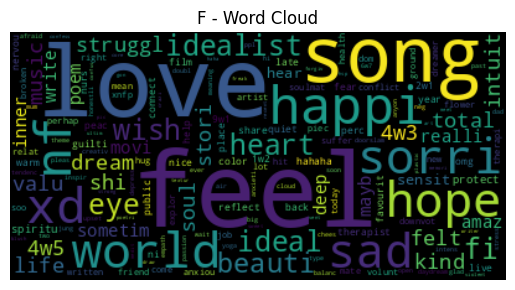

Highest weighted word for J: ni
Highest weighted word for P: ne


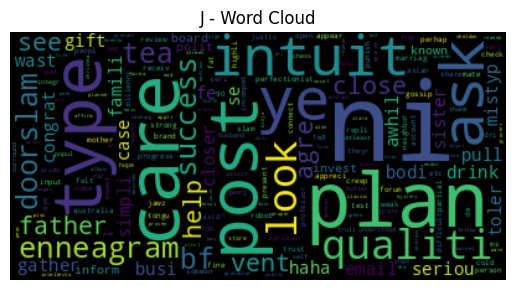

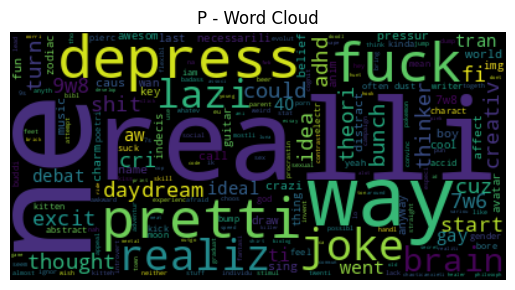

In [ ]:
for idx, dim in enumerate(['dim1', 'dim2', 'dim3', 'dim4']):
  p_types = ['E/I', 'S/N', 'T/F', 'J/P']

  words = vrizers[dim].get_feature_names_out()
  idx_upper = np.argpartition(scores[idx], -1000)[-1000:]
  idx_lower = np.argpartition(scores[idx], 1000)[:1000]

  print(f"Highest weighted word for {p_types[idx][0]}: {words[np.argmax(scores[idx])]}")
  print(f"Highest weighted word for {p_types[idx][2]}: {words[np.argmin(scores[idx])]}")


  # UPPER
  upper_words = words[idx_upper].tolist()
  upper_scores = scores[idx][idx_upper].tolist()

  upper_df = pd.DataFrame({'words':upper_words, 'scores':upper_scores})
  upper_df['weight'] = upper_df['scores']/(upper_df['scores'].max())

  upper_word_freqs = dict(zip(upper_df['words'], upper_df['weight']))
  upper_wordcloud = WordCloud().generate_from_frequencies(upper_word_freqs)

  # Display the generated image
  plt.imshow(upper_wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"{p_types[idx][0]} - Word Cloud")
  plt.show()

  # LOWER 

  lower_words = words[idx_lower].tolist()
  lower_scores = scores[idx][idx_lower].tolist()

  lower_df = pd.DataFrame({'words':lower_words, 'scores':lower_scores})
  lower_df['weight'] = lower_df['scores']/(lower_df['scores'].max())

  lower_word_freqs = dict(zip(lower_df['words'], lower_df['weight']))
  lower_wordcloud = WordCloud().generate_from_frequencies(lower_word_freqs)

  # Display the generated image
  plt.imshow(lower_wordcloud, interpolation='bilinear')
  plt.title(f"{p_types[idx][2]} - Word Cloud")
  plt.axis("off")
  plt.show()



Predict on Chronic Pain dataset

In [ ]:
def predictOnSample(df, model, vectorizer, dims):
    # function assumes the input dataframe is already preprocessed

  df_labelled = df.copy()
  for idx, dim in enumerate(dims):

    p_types = ['E/I', 'S/N', 'T/F', 'J/P']

    vectorizedText = vectorizer[dim].transform(df['posts']).toarray()

    prediction = model[dim].predict(vectorizedText)

    pred_label = [p_types[idx][2] if p == 0 else p_types[idx][0] for p in prediction]

    df_labelled[dim] = pred_label
    
  return df_labelled
        

In [ ]:
df_pain = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH,'processed_reddit_pain.csv'))

In [ ]:
dims = ['dim1', 'dim2', 'dim3', 'dim4']
df_labelled = predictOnSample(df_pain, models, vrizers, dims)

In [ ]:
df_labelled

posts dim1 dim2 dim3 dim4
0     agre tint lip balm lipstick look realli good l...    I    N    F    J
1     pet shop got ta make care isnt ani vitamin e a...    E    S    T    P
2     combo jack tri desktop split work fine issu st...    E    S    T    J
3     ahh catch well doctor alway told even type oi ...    E    S    F    P
4     hope get aggress fast somehow find peopl docto...    I    N    F    P
...                                                 ...  ...  ...  ...  ...
3661  nut one onli calor dens mean susten still find...    I    N    F    P
3662  fozzi bear imagin delet scene somewher run rac...    E    N    T    P
3663  bathtub first time girl climb shoulder wa wort...    E    S    F    J
3664  hey realli appreci comment ive watch video neu...    E    S    F    J
3665  mod past ha one relat sub sad see ha ban due u...    E    S    T    P

[3666 rows x 5 columns]

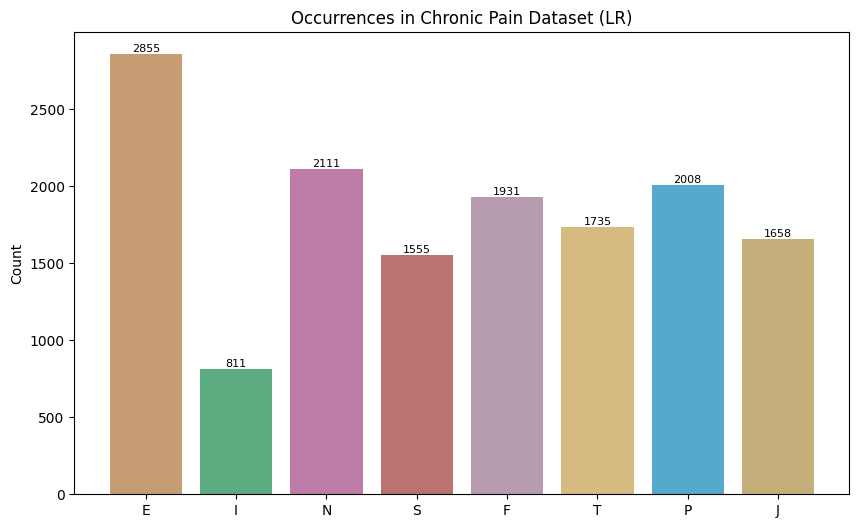

In [ ]:
plt.figure(figsize=(10, 6))

# Create a dictionary to store the counts for each column
counts = {}

# Iterate over the columns and get the counts for each unique value
for col in df_labelled.columns:

  if col != 'posts':

    counts[col] = df_labelled[col].value_counts()

    # Plot the counts as a bar chart
    plt.bar(counts[col].index, counts[col].values, alpha=0.5)

    for i, v in enumerate(counts[col].values):
        plt.bar_label(plt.bar(counts[col].index[i], counts[col].values[i], alpha=0.5), 
                      labels=[counts[col].values[i]], label_type='edge', fontsize=8)

# Add a label for the y-axis
plt.ylabel('Count')

# Add a title for the plot
plt.title('Occurrences in Chronic Pain Dataset (LR)')


# Show the plot
plt.show()